# Appendix
Avi Bauer & Matthew Duffy

In [1]:
# Step 0.0: import our libraries

import pandas as pd
import numpy as np
import re
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)
#Bulk imported all models for now

In [2]:
# Step 0.1: Access Google Drive.

# import requisite library
from google.colab import drive

# login and verity that you want to use it
drive.mount('/content/drive')

Mounted at /content/drive


## **Appendix 1**: *Question 1:* Clean `police_baseline data.csv` and merge with pre-merged `Police_Station.csv`

In [37]:
# Step 1: Locate and download our data files

# identify the root directory
root_dir = "/content/drive/My Drive/Data - Human Centered DS/"

# identify the location of the relevant data files
pol_b_URL = root_dir + "Police survey/csv/police_baseline data.csv"
pol_stat_URL = root_dir + "Cleaned Data/Question_1/Police_Stations.csv"

# import our data files
pol_base = pd.read_csv(pol_b_URL)
pol_stat = pd.read_csv(pol_stat_URL)

In [5]:
# check what columns pol_base offers
display(pol_base.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1950 non-null   int64  
 1   b_uid                   1950 non-null   int64  
 2   gender                  1950 non-null   object 
 3   b_pol_impt              1918 non-null   float64
 4   b_thana_impt            1924 non-null   float64
 5   b_wcase                 1948 non-null   object 
 6   b_effective             1943 non-null   object 
 7   b_helpful               1947 non-null   object 
 8   b_add_officer           1948 non-null   object 
 9   b_add_female            1949 non-null   object 
 10  b_female_better         1947 non-null   object 
 11  b_sensitivity           1945 non-null   float64
 12  uid                     1139 non-null   float64
 13  attrit                  1950 non-null   float64
 14  ps_code                 1950 non-null   

None

In [6]:
# Step 2: Isolate relevant columns

# We just want b_.* columns + uid (index for merging) and attrit

# extract all column names
all_cols = list(pol_base)

# get all the b_.* columns, uid, and attrit using regex
reg = re.compile("b_.*|uid|attrit")
b_cols = list(filter(reg.match,all_cols))
# print(b_cols) # debugger

# get a subset of our original column set
pol_base_extract = pol_base[b_cols]
# print(pol_base_extract.columns.tolist()) # debugger

# let's review what's left
pol_base_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   b_uid            1950 non-null   int64  
 1   b_pol_impt       1918 non-null   float64
 2   b_thana_impt     1924 non-null   float64
 3   b_wcase          1948 non-null   object 
 4   b_effective      1943 non-null   object 
 5   b_helpful        1947 non-null   object 
 6   b_add_officer    1948 non-null   object 
 7   b_add_female     1949 non-null   object 
 8   b_female_better  1947 non-null   object 
 9   b_sensitivity    1945 non-null   float64
 10  uid              1139 non-null   float64
 11  attrit           1950 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 182.9+ KB


In [7]:
# Step 3: deal with nulls

# Note above, there are many fewer uid values than any other column
# (all of which, aside from uid, also contail null values).
# We're merging on uid, so that becomes our limiting factor.
# we should probably drop any row missing uid.

# remove columns with a null value
pol_b_short = pol_base_extract.dropna(subset='uid',axis=0)

# let's see where we're at
pol_b_short.isna().sum()

,0
b_uid,0
b_pol_impt,16
b_thana_impt,16
b_wcase,2
b_effective,5
b_helpful,2
b_add_officer,0
b_add_female,0
b_female_better,2
b_sensitivity,4


In [8]:
# dang still a few nulls, but no more than ~20.
# let's drop these, as there isn't a good way
# to estimate an "average" value here.
pol_b_clean =  pol_b_short.dropna(subset=list(pol_b_short),axis=0)

# let's see where we're at, again
pol_b_clean.isna().sum()
# result: no nulls left!

,0
b_uid,0
b_pol_impt,0
b_thana_impt,0
b_wcase,0
b_effective,0
b_helpful,0
b_add_officer,0
b_add_female,0
b_female_better,0
b_sensitivity,0


In [9]:
# before we merge let's double-check what our values look like
pol_b_clean.head()
pol_b_clean.info()
# result: about what we can expect.

<class 'pandas.core.frame.DataFrame'>
Index: 1106 entries, 2 to 1949
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   b_uid            1106 non-null   int64  
 1   b_pol_impt       1106 non-null   float64
 2   b_thana_impt     1106 non-null   float64
 3   b_wcase          1106 non-null   object 
 4   b_effective      1106 non-null   object 
 5   b_helpful        1106 non-null   object 
 6   b_add_officer    1106 non-null   object 
 7   b_add_female     1106 non-null   object 
 8   b_female_better  1106 non-null   object 
 9   b_sensitivity    1106 non-null   float64
 10  uid              1106 non-null   float64
 11  attrit           1106 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 112.3+ KB


In [ ]:
# one last detail: UID should be an integer.
pol_b_clean = pol_b_clean.astype({'uid':int})

In [ ]:
# Step 4: Merge!

# I believe these are duplicate-named columns: check
pol_stat.info()

# Result: So all but attrit are repeated column names.
# For future studying, let's leave both "versions" in.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1904 non-null   int64  
 1   gender                  1904 non-null   object 
 2   e_wcase                 1904 non-null   object 
 3   e_effective             1904 non-null   object 
 4   e_false_case            1904 non-null   object 
 5   e_helpful               1904 non-null   object 
 6   e_add_officer           1904 non-null   object 
 7   e_add_female            1904 non-null   object 
 8   e_female_better         1904 non-null   object 
 9   e_taken_seriously       1904 non-null   object 
 10  e_prof_dev              1904 non-null   object 
 11  e_work_help             1904 non-null   object 
 12  e_pol_impt              1904 non-null   float64
 13  e_thana_impt            1904 non-null   float64
 14  e_sensitivity           1904 non-null   

In [ ]:
# NOTABLY AND UNFORTUNATELY:
# We're going to loose some data from pol_stat,
# because we want rows that have baseline AND endline values.
# So we're going to try an inner merge.

# go for it
pol_base_end = pd.merge(pol_stat,pol_b_clean,how='inner',on='uid',suffixes=(None,'_base'))

In [ ]:
# big breath and let's look
display(pol_base_end.info())
display(pol_base_end.head())

# result: looks good!!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1009 non-null   int64  
 1   gender                  1009 non-null   object 
 2   e_wcase                 1009 non-null   object 
 3   e_effective             1009 non-null   object 
 4   e_false_case            1009 non-null   object 
 5   e_helpful               1009 non-null   object 
 6   e_add_officer           1009 non-null   object 
 7   e_add_female            1009 non-null   object 
 8   e_female_better         1009 non-null   object 
 9   e_taken_seriously       1009 non-null   object 
 10  e_prof_dev              1009 non-null   object 
 11  e_work_help             1009 non-null   object 
 12  e_pol_impt              1009 non-null   float64
 13  e_thana_impt            1009 non-null   float64
 14  e_sensitivity           1009 non-null   

None

,uid,gender,e_wcase,e_effective,e_false_case,e_helpful,e_add_officer,e_add_female,e_female_better,e_taken_seriously,...,b_pol_impt_base,b_thana_impt_base,b_wcase_base,b_effective_base,b_helpful_base,b_add_officer_base,b_add_female_base,b_female_better_base,b_sensitivity_base,attrit
0,2141733,male,too much attention,very effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,...,0.0,0.0,enough attention,very effective,helpful,more effective,much less effective,female,8.0,0.0
1,2141734,male,too much attention,effective,very uncommon,helpful,much more effective,Less effective,female,agree,...,0.0,0.0,too much attention,very effective,very helpful,much more effective,much less effective,female,8.0,0.0
2,2141739,male,too much attention,very effective,very uncommon,very helpful,more effective,Less effective,female,agree,...,0.0,0.0,enough attention,effective,helpful,more effective,much less effective,male,5.0,0.0
3,2141742,male,too much attention,very effective,uncommon,helpful,much more effective,No difference,no difference,agree,...,0.0,0.0,too much attention,very effective,helpful,more effective,much less effective,male,8.0,0.0
4,2141740,male,enough attention,effective,uncommon,very helpful,much more effective,Less effective,female,strongly agree,...,0.0,0.0,too much attention,very effective,helpful,much more effective,less effective,female,6.0,0.0


In [ ]:
# Step 5: Output

# define our path + filename
out_path = root_dir + "Cleaned Data/Question_1/Police_full.csv"

# pol_base_end.to_csv(out_path,index=False)

## **Appendix 2**: *Question 2:* Merge `admin_wide data.csv`with `police_station personnel data.csv` and rerun our models using (1) 180 averaged points and (2) all unaveraged points

In [4]:
# snag our admin files

# identify the root directory
root_dir = "/content/drive/My Drive/Data - Human Centered DS/"

al = pd.read_csv(root_dir + 'Admin/csv/admin_long data.csv')
aw = pd.read_csv(root_dir + 'Admin/csv/admin_wide data.csv')
st = pd.read_csv(root_dir + 'Police survey/csv/police_station personnel data.csv')

In [5]:
# let's excise just what we need from aw
a_wide = aw[['ps_code', 'month', 'b_dial100_count', 'e_dial100_count']]
a_wide.head()

,ps_code,month,b_dial100_count,e_dial100_count
0,1001.0,1.0,26.0,30.0
1,1002.0,1.0,15.0,26.0
2,1003.0,1.0,12.0,11.0
3,1004.0,1.0,9.0,19.0
4,1005.0,1.0,12.0,17.0


In [6]:
# we also need a new collumn, dial100_diff
# which is the e_ - b_ total
a_wide['dial100_diff'] = a_wide['e_dial100_count'] - a_wide['b_dial100_count']
a_wide['month'].value_counts()

<ipython-input-6-f52b20d2b8a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_wide['dial100_diff'] = a_wide['e_dial100_count'] - a_wide['b_dial100_count']


,count
month,
1.0,180
2.0,180
3.0,180
5.0,180
6.0,180
7.0,180
8.0,180
9.0,180
10.0,180


In [7]:
# let's add a dial100_diff column
a_wide['dial100_diff'] = a_wide['e_dial100_count'] - a_wide['b_dial100_count']

a_wide.head()

<ipython-input-7-fba5d81d39f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_wide['dial100_diff'] = a_wide['e_dial100_count'] - a_wide['b_dial100_count']


,ps_code,month,b_dial100_count,e_dial100_count,dial100_diff
0,1001.0,1.0,26.0,30.0,4.0
1,1002.0,1.0,15.0,26.0,11.0
2,1003.0,1.0,12.0,11.0,-1.0
3,1004.0,1.0,9.0,19.0,10.0
4,1005.0,1.0,12.0,17.0,5.0


In [8]:
# let's group by station!
a_stat = a_wide.groupby(['ps_code'])

# fresh dataframe
a_sw = pd.DataFrame()

# now add a column of the mean differences
a_sw['dial100_mean'] = a_stat['dial100_diff'].mean()

a_sw.head() # looks like the index is actually ps_code, nice

,dial100_mean
ps_code,
1001.0,-6.818182
1002.0,0.454545
1003.0,-5.818182
1004.0,2.090909
1005.0,0.090909


In [9]:
# let's look at st now
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              180 non-null    int64  
 1   e_total_surveyed        180 non-null    float64
 2   e_female_surveyed       180 non-null    float64
 3   e_male_surveyed         180 non-null    float64
 4   ps_code                 180 non-null    float64
 5   e_total_staff           180 non-null    float64
 6   e_female_staff          180 non-null    float64
 7   e_total_officers        180 non-null    float64
 8   e_female_officers       180 non-null    float64
 9   e_male_staff            180 non-null    float64
 10  e_male_officers         180 non-null    float64
 11  e_female_sho            180 non-null    float64
 12  b_total_staff           180 non-null    float64
 13  b_female_staff          180 non-null    float64
 14  b_male_staff            180 non-null    fl

In [10]:
# let's grab the subset we need
stations = st[['ps_code','population','urban','strat_pca','group','treatment']]

stations.head()

,ps_code,population,urban,strat_pca,group,treatment
0,1001.0,129345,Rural,-0.234041,women officers,Treatment
1,1002.0,170000,Rural,-0.960574,control,Control
2,1003.0,102467,Rural,1.042663,control,Control
3,1004.0,54000,Rural,-1.590761,regular mhd,Treatment
4,1005.0,76376,Rural,-1.570695,women officers,Treatment


In [11]:
# let's join!
dials_stat = stations.merge(a_sw,how='left',on='ps_code')

# also convert categorical variables to dummy variables
dials_stat = pd.get_dummies(dials_stat, drop_first=True)

# dials_stat['urban_Urban'].value_counts()
dials_stat.head()

,ps_code,population,strat_pca,dial100_mean,urban_Urban,group_regular mhd,group_women officers,treatment_Treatment
0,1001.0,129345,-0.234041,-6.818182,False,False,True,True
1,1002.0,170000,-0.960574,0.454545,False,False,False,False
2,1003.0,102467,1.042663,-5.818182,False,False,False,False
3,1004.0,54000,-1.590761,2.090909,False,True,False,True
4,1005.0,76376,-1.570695,0.090909,False,False,True,True


In [12]:
# quick check for nulls
dials_stat.info() # none!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ps_code               180 non-null    float64
 1   population            180 non-null    int64  
 2   strat_pca             180 non-null    float64
 3   dial100_mean          180 non-null    float64
 4   urban_Urban           180 non-null    bool   
 5   group_regular mhd     180 non-null    bool   
 6   group_women officers  180 non-null    bool   
 7   treatment_Treatment   180 non-null    bool   
dtypes: bool(4), float64(3), int64(1)
memory usage: 6.5 KB


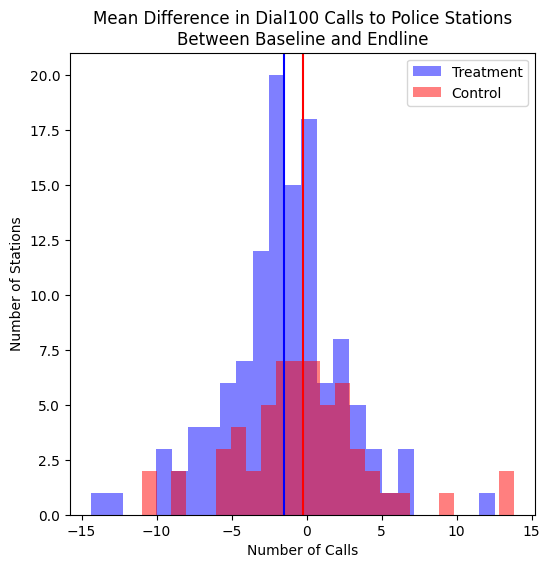

In [29]:
# let's visualize the spread here via a histogram.
hist_fig = plt.figure(figsize=(6,6))

# plot some data
_ = plt.hist(dials_stat['dial100_mean'][dials_stat['treatment_Treatment'] == True], color = 'blue', alpha=0.5, bins=25, label="Treatment")
_ = plt.hist(dials_stat['dial100_mean'][dials_stat['treatment_Treatment'] == False], color = 'red', alpha=0.5, bins=25, label="Control")

# add mean lines
_ = plt.axvline(x=dials_stat['dial100_mean'][dials_stat['treatment_Treatment'] == True].mean(),c='blue')
_ = plt.axvline(x=dials_stat['dial100_mean'][dials_stat['treatment_Treatment'] == False].mean(),c='red')

# add some labels
_ = plt.title("Mean Difference in Dial100 Calls to Police Stations\nBetween Baseline and Endline")
_ = plt.ylabel("Number of Stations")
_ = plt.xlabel("Number of Calls")
_ = plt.legend()

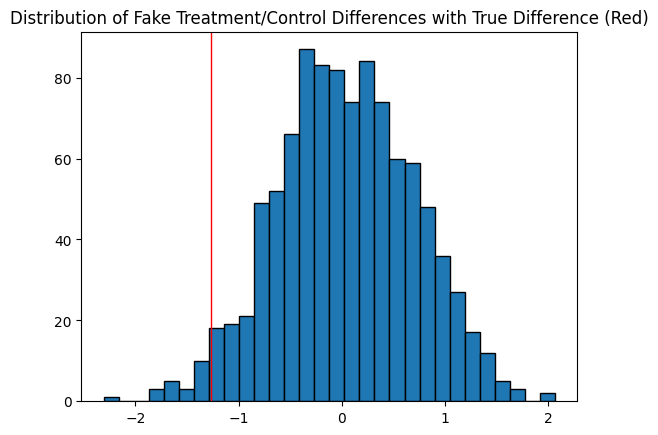

In [34]:
# oh that's an interesting difference of mean: is it statistically significant?

vector_of_differences = np.empty(1000)    # Make an empty vector to store all our differences

# Do the indented stuff 999 times (see the for loop introduction from W2!)
for i in range(999): # This does something 999 times: indices 0:998
    # Permute the treatment labels
    dials_stat['random_fake_treatment'] = np.random.permutation(dials_stat['treatment_Treatment'])
    # Calculate the fake difference and store it in the "ith" spot in the vector
    vector_of_differences[i] = dials_stat[dials_stat['random_fake_treatment'] == True]['dial100_mean'].mean() - \
                               dials_stat[dials_stat['random_fake_treatment'] == False]['dial100_mean'].mean()

# Add real difference to the end of the list
true_diff = dials_stat[dials_stat['treatment_Treatment'] == True]['dial100_mean'].mean() - \
                               dials_stat[dials_stat['treatment_Treatment'] == False]['dial100_mean'].mean()
vector_of_differences[999] = true_diff

# Plot the distribution of real and fake differences
plt.hist(vector_of_differences, bins = 30, edgecolor = 'black') # Set up a histogram
plt.axvline(x = true_diff, color = 'red', linewidth = 1) # Add a vertical red line
plt.title("Distribution of Fake Treatment/Control Differences with True Difference (Red)")
plt.show()

In [35]:
# calculate our P-value
p_value = (np.abs(vector_of_differences) >= np.abs(true_diff)).mean()
print("P-value for treatment-control difference:", p_value)

# 0.061 - that's so close to significant...

P-value for treatment-control difference: 0.059


In [13]:
# NOW let's model
y = dials_stat['treatment_Treatment']
X = dials_stat[['population',
               'strat_pca',
               'dial100_mean',
               'urban_Urban'
               ]]

# set scaler
scaler = skpre.MinMaxScaler()

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# initiate a logistic model
model = linear_model.LogisticRegression(class_weight='balanced')

# feed our data through a scaler -> model pipeline
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model
y_preds = pipe.predict(X_test)

# hold our breath and check accuracy and F1
accuracy = metrics.accuracy_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
print(f'Accuracy = {accuracy}, F1 = {f1}')

Accuracy = 0.5555555555555556, F1 = 0.6363636363636364


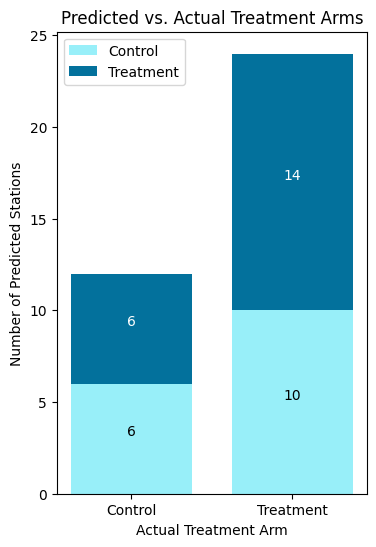

In [14]:
# let's do a visualization to see just how bad it is!

# call confusion matrix using test data and the predictions
confusionMatrix = metrics.confusion_matrix(y_test, y_preds)

# arrange our data properly
arm_labs = ['Control','Treatment']
arm_vals = {
    'Control': [[confusionMatrix[0,0],confusionMatrix[1,0]],"xkcd:robin's egg blue"],
    'Treatment': [[confusionMatrix[0,1],confusionMatrix[1,1]],'xkcd:ocean blue']
}

# set up our figure
fig, ax = plt.subplots(figsize=(4,6))
bottom = np.zeros(2)
width = 0.75

for lab, arm in arm_vals.items():
    p = ax.bar(arm_labs, arm[0], width, label=lab, bottom=bottom,color=arm[1])
    for i,bar in enumerate(p):
      if bottom[i] > 0:
        c = 'white'
      else:
         c = 'black'

      ax.text(
          bar.get_x() + bar.get_width() / 2, (bar.get_height() / 2) + bottom[i],  # Center text vertically within the bar
          f'{bar.get_height():.0f}', ha='center', va='bottom', color=c, fontsize=10
      )
    bottom += arm[0]

_ = ax.set_title("Predicted vs. Actual Treatment Arms")
_ = ax.set_xlabel("Actual Treatment Arm")
_ = ax.set_ylabel("Number of Predicted Stations")
ax.legend(loc="upper left")

# plt.savefig(f'/content/drive/MyDrive/Data - Human Centered DS/Plots/confusion_bars.png', bbox_inches='tight', dpi=400)
plt.show()

In [16]:
# let's return to just before we grouped our data:
# ps_code, dial100_diff in: a_wide
# heterogeneity in: stations
display(a_wide.info())
display(stations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ps_code          1980 non-null   float64
 1   month            1980 non-null   float64
 2   b_dial100_count  1980 non-null   float64
 3   e_dial100_count  1980 non-null   float64
 4   dial100_diff     1980 non-null   float64
dtypes: float64(5)
memory usage: 77.5 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ps_code     180 non-null    float64
 1   population  180 non-null    int64  
 2   urban       180 non-null    object 
 3   strat_pca   180 non-null    float64
 4   group       180 non-null    object 
 5   treatment   180 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 8.6+ KB


None

In [17]:
# we want to left-join a_wide and stations
# desired result: 1980 entries
all_pts = a_wide.merge(stations,how='left',on='ps_code')

# get those dummy values
all_pts = pd.get_dummies(all_pts, drop_first=True)

# hold our breath and look!
all_pts.info() # nice, it worked!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ps_code               1980 non-null   float64
 1   month                 1980 non-null   float64
 2   b_dial100_count       1980 non-null   float64
 3   e_dial100_count       1980 non-null   float64
 4   dial100_diff          1980 non-null   float64
 5   population            1980 non-null   int64  
 6   strat_pca             1980 non-null   float64
 7   urban_Urban           1980 non-null   bool   
 8   group_regular mhd     1980 non-null   bool   
 9   group_women officers  1980 non-null   bool   
 10  treatment_Treatment   1980 non-null   bool   
dtypes: bool(4), float64(6), int64(1)
memory usage: 116.1 KB


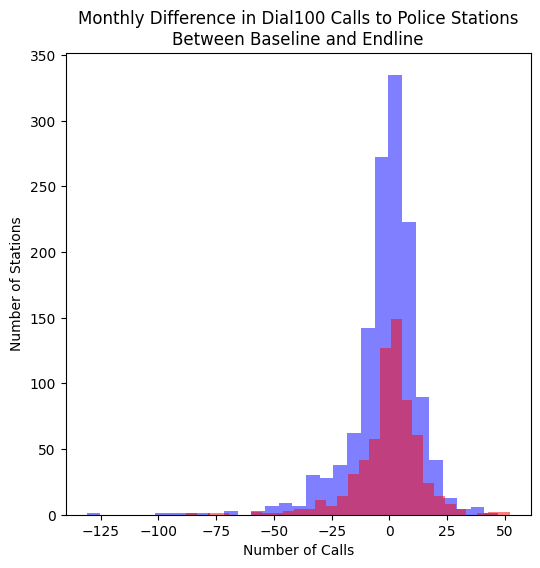

In [24]:
# let's visualize the spread here via a histogram.
hist_fig = plt.figure(figsize=(6,6))

# plot some data
_ = plt.hist(all_pts['dial100_diff'][all_pts['treatment_Treatment'] == True], color = 'blue', alpha=0.5, bins=30, label="Treatment")
_ = plt.hist(all_pts['dial100_diff'][all_pts['treatment_Treatment'] == False], color = 'red', alpha=0.5, bins=30, label="Control")

# add some labels
_ = plt.title("Monthly Difference in Dial100 Calls to Police Stations\nBetween Baseline and Endline")
_ = plt.ylabel("Number of Stations")
_ = plt.xlabel("Number of Calls")

In [18]:
# let's model again!
y = all_pts['treatment_Treatment']
X = all_pts[['population',
               'strat_pca',
               'dial100_diff',
               'urban_Urban'
               ]]

# set scaler
scaler = skpre.MinMaxScaler()

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# initiate a logistic model
model = linear_model.LogisticRegression(class_weight='balanced')

# feed our data through a scaler -> model pipeline
pipe = pipeline.make_pipeline(scaler, model)
pipe.fit(X_train, y_train) #fit_transforms for standardization before fitting model
y_preds = pipe.predict(X_test)

# hold our breath and check accuracy and F1
accuracy = metrics.accuracy_score(y_test, y_preds)
f1 = metrics.f1_score(y_test, y_preds)
print(f'Accuracy = {accuracy}, F1 = {f1}')

Accuracy = 0.4797979797979798, F1 = 0.5422222222222223


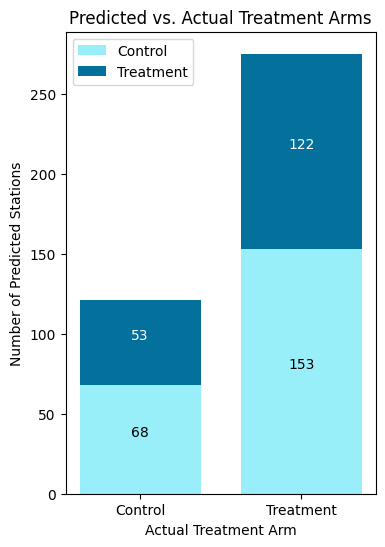

In [19]:
# let's do a visualization to see just how bad it is!

# call confusion matrix using test data and the predictions
confusionMatrix = metrics.confusion_matrix(y_test, y_preds)

# arrange our data properly
arm_labs = ['Control','Treatment']
arm_vals = {
    'Control': [[confusionMatrix[0,0],confusionMatrix[1,0]],"xkcd:robin's egg blue"],
    'Treatment': [[confusionMatrix[0,1],confusionMatrix[1,1]],'xkcd:ocean blue']
}

# set up our figure
fig, ax = plt.subplots(figsize=(4,6))
bottom = np.zeros(2)
width = 0.75

for lab, arm in arm_vals.items():
    p = ax.bar(arm_labs, arm[0], width, label=lab, bottom=bottom,color=arm[1])
    for i,bar in enumerate(p):
      if bottom[i] > 0:
        c = 'white'
      else:
         c = 'black'

      ax.text(
          bar.get_x() + bar.get_width() / 2, (bar.get_height() / 2) + bottom[i],  # Center text vertically within the bar
          f'{bar.get_height():.0f}', ha='center', va='bottom', color=c, fontsize=10
      )
    bottom += arm[0]

_ = ax.set_title("Predicted vs. Actual Treatment Arms")
_ = ax.set_xlabel("Actual Treatment Arm")
_ = ax.set_ylabel("Number of Predicted Stations")
ax.legend(loc="upper left")

# plt.savefig(f'/content/drive/MyDrive/Data - Human Centered DS/Plots/confusion_bars.png', bbox_inches='tight', dpi=400)
plt.show()

## **Appendix 3**: Can we identify the opinions of a single police woman?

In [41]:
# first, let's snag our data
pol_b_URL = root_dir + "Police survey/csv/police_baseline data.csv"
pol_e_URL = root_dir + "Police survey/csv/police_full data.csv"
pol_s_URL = root_dir + "Cleaned Data/Question_1/Police_full.csv"

pb = pd.read_csv(pol_b_URL)
pe = pd.read_csv(pol_e_URL)
ps = pd.read_csv(pol_s_URL)

# see what we've got
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1009 non-null   int64  
 1   gender                  1009 non-null   object 
 2   e_wcase                 1009 non-null   object 
 3   e_effective             1009 non-null   object 
 4   e_false_case            1009 non-null   object 
 5   e_helpful               1009 non-null   object 
 6   e_add_officer           1009 non-null   object 
 7   e_add_female            1009 non-null   object 
 8   e_female_better         1009 non-null   object 
 9   e_taken_seriously       1009 non-null   object 
 10  e_prof_dev              1009 non-null   object 
 11  e_work_help             1009 non-null   object 
 12  e_pol_impt              1009 non-null   float64
 13  e_thana_impt            1009 non-null   float64
 14  e_sensitivity           1009 non-null   

In [43]:
# let's find all responses where b_female_staff == 1
ps_singles = ps[ps['b_female_staff'] == 1]

ps_singles.info() # 167 entries

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 51 to 1002
Data columns (total 79 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     167 non-null    int64  
 1   gender                  167 non-null    object 
 2   e_wcase                 167 non-null    object 
 3   e_effective             167 non-null    object 
 4   e_false_case            167 non-null    object 
 5   e_helpful               167 non-null    object 
 6   e_add_officer           167 non-null    object 
 7   e_add_female            167 non-null    object 
 8   e_female_better         167 non-null    object 
 9   e_taken_seriously       167 non-null    object 
 10  e_prof_dev              167 non-null    object 
 11  e_work_help             167 non-null    object 
 12  e_pol_impt              167 non-null    float64
 13  e_thana_impt            167 non-null    float64
 14  e_sensitivity           167 non-null    float

In [51]:
# let's filter again, for gender == female
ps_onlyf = ps_singles[ps_singles['gender'] == 'female']

ps_onlyf.shape # 19 rows!!

(19, 79)

In [49]:
# what rows identify the station?
ps_onlyf_station = ps_onlyf[['uid','gender','ps_code','population','urban','b_total_staff','b_female_staff','b_total_officers','b_female_officers','b_female_sho']]

ps_onlyf_station.head()

,uid,gender,ps_code,population,urban,b_total_staff,b_female_staff,b_total_officers,b_female_officers,b_female_sho
56,2154232,female,2020.0,125000,Rural,25,1,5,0,0
59,2154241,female,2020.0,125000,Rural,25,1,5,0,0
184,2345732,female,3030.0,150000,Urban,43,1,11,0,0
394,2453032,female,4067.0,46450,Rural,18,1,5,0,0
451,2543832,female,5078.0,215000,Urban,73,1,21,0,0


In [ ]:
# ... I think we could do this if we looked some numbers up.